  **Assignment 3**
  
  Name: Tao He
  
  Discussion Partner: Yifan Zhang

In this piece of code, we are going to process and analyze the data we collect from **Twitter**, **Wikipedia**, **ABC** and **Fox news**.



Task 1. With your implemented code provided in the first lab section, get the "article" texts of the wikipedia page of "fishing" and its all linked wiki pages. Your saved data should contain the titles of the wiki pages and their article texts.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install spacy and related package(s)

!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [2]:
#First, import the needed libraries for scraping data from Wikipedia webpages.
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time # for setting up a delay on getting htmls from wiki server.
from tqdm import tqdm

import csv
import sys
import re
import spacy
import operator
from nltk.corpus import stopwords

In [3]:
# First, get the page info from wiki server given an URL.
def getPageFromWiki(url):
    # get URL
    page = requests.get(url)
 
    # scrape webpage
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup

# Second, get the title of the wiki page
def getHeading(soup):
    heading = soup.find('title').text
    return heading

# Third, get the article part of the wiki page 
def getContent(page):
    content = []
    texts = page.find_all('p')
    for text in texts:
        content.append(text.get_text())
    return content

# Fourth, get the links that the article part mentioned and specifically, linking to other wiki pages.
def getLinks(page):
    linksDict = {}

    links = page.find_all('a', href = True, title = True)
    for link in links:
        if (not link.get('href').startswith('https://')):
            url = 'https://en.wikipedia.org' + link.get('href')
            linksDict[link.get('title')] = url
        else:
            url = link.get('href')
            linksDict[link.get('title')] = url
            
    return linksDict

In [5]:
pageDict = {}

page = getPageFromWiki('https://en.wikipedia.org/wiki/Fishing') # scrap the main page we want. 
header = getHeading(page)
content = getContent(page)
pageDict[header] = content
print(pageDict)

linksDict = getLinks(page) # get the links contained in the article part of the page.
print("a set of {} links are found.".format(len(linksDict)))

for title in tqdm(list(linksDict.keys())): # set up a loop to , set a delay at each iteration
  url = linksDict[title]
  page = getPageFromWiki(url)
  header = getHeading(page)
  content = getContent(page)
  pageDict[header] = content
  time.sleep(1) # Remember to set a delay >=1 second so you won't break the server.

print("a size of {} content dictionary is built.".format(len(pageDict)))

{'Fishing - Wikipedia': ['\n', 'Fishing is the activity of trying to catch fish. Fish are often caught as wildlife from the natural environments, but may also be caught from stocked bodies of water such as ponds, canals, park wetlands and reservoirs. Fishing techniques include hand-gathering, spearing, netting, angling, shooting and trapping, as well as more destructive and often illegal techniques such as electrocution, blasting and poisoning.\n', 'The term fishing broadly includes catching aquatic animals other than fish, such as crustaceans (shrimp/lobsters/crabs), shellfish, cephalopods (octopus/squid) and echinoderms (starfish/sea urchins). The term is not normally applied to harvesting fish raised in controlled cultivations (fish farming). Nor is it normally applied to hunting aquatic mammals, where terms like whaling and sealing are used instead.\n', 'Fishing has been an important part of human culture since hunter-gatherer times, and is one of the few food production activities

100%|██████████| 591/591 [12:14<00:00,  1.24s/it]

a size of 533 content dictionary is built.


In [6]:
# Lastly, save your contents and corresponding title in a .csv file.
driveFolderDirectory = '/content/drive/My Drive/CS505/wikiContents.csv'
pathToSave = driveFolderDirectory

with open(pathToSave, 'w', newline='') as csvfile:
  fieldnames = ['idx','wikiTitle', 'wikiContents']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()
  for i,wikiContentKey in enumerate(pageDict.keys()):
    writer.writerow({'idx': i, 'wikiTitle': wikiContentKey,'wikiContents': pageDict[wikiContentKey]})

In [7]:
import sys
csv.field_size_limit(sys.maxsize)

# Here is a function you could load the text data if your saved data follows
# the format we provide the in first lab section code.

def loadWikiTexts(csvPath):
  wikiRawTextDict = {}
  with open(csvPath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      wikiRawTextDict[row['wikiTitle']] = row['wikiContents']
  return wikiRawTextDict

In [8]:
# load wiki data:
csvPath = "/content/drive/My Drive/CS505/wikiContents.csv"
WikiRawTextDict = loadWikiTexts(csvPath)

Task 2. With library Spacy and Regular Expression (re), preprocess our scraped data to:

- Remove all the references texts [...] in the scraped data  ([re](https://docs.python.org/3/library/re.html)). 
- [Sentence split](https://spacy.io/usage/linguistic-features#sbd) (Spacy).
- [Tokenize](https://spacy.io/usage/linguistic-features#tokenization) (Spacy)
- [Lemmatize](https://spacy.io/usage/linguistic-features#lemmatization) (Spacy)
- [Lower case](https://www.programiz.com/python-programming/methods/string/lower) (String)


In [9]:
keys = list(WikiRawTextDict.keys())

In [10]:
def preprocess(wikiTextDict):
    for key in tqdm(list(wikiTextDict.keys())):
      content = wikiTextDict[key]

      # sub-task 1: remove all the references texts "[...]"
      content_1 = re.sub(r"[\[0-9*\]]", "", content)
      
      # sub-task 2: segment all the sentences in the wiki texts. 
      # sub-task 5: lower-case the tokens from sub-task 3/4.
      nlp = spacy.load("en_core_web_sm")
      doc = nlp(content_1)
      assert doc.has_annotation("SENT_START")
      content_2 = []
      for sent in doc.sents:
        content_2.append(sent.text.lower())

      # sub-task 3: tokenize the sentences from sub-task 2.
      # sub-task 4: lemmatize the tokens from sub-task 3.
      content_3 = []
      lemmatizer = nlp.get_pipe("lemmatizer")
      for sent in content_2:
        doc = nlp(sent)
        words = []
        for token in doc:
          words.append(token.lemma_)
        content_3.append(words)
    
      wikiTextDict[key] = content_3
      
    return wikiTextDict

In [11]:
wikiDict = preprocess(WikiRawTextDict)

100%|██████████| 533/533 [11:32<00:00,  1.30s/it]


Task 3. Construct a dictionary of the vocabulary for your scraped data (all texts). The keys are the word types and the values are the count of the appearances of the word (frequency).

In [12]:
def computeFreq(wikiTextDict):
    frequency_list = {}
    for key in list(wikiTextDict.keys()):
      for sent in wikiTextDict[key]:
        for i in sent:
          if i in frequency_list:
            frequency_list[i] += 1
          else:
            frequency_list[i] = 1
    return(frequency_list)

In [13]:
freqDict = computeFreq(wikiDict)

Task 4. What are the top 20 non-stop, non-punctuation words in the vocabulary according to frequency?

In [14]:
def computeTop20Words(freqDict):
    SortedDict = dict(sorted(freqDict.items(), key = operator.itemgetter(1), reverse = True))
    
    keys = list(SortedDict.keys())
    keys_non_sw = []
    for key in keys:
      if not key in stopwords.words():
        keys_non_sw.append(key)

    punctuations = [',', '.', '\n ', '-', '(', ')', ' ', '"', "'s", '\xa0', ':', ';', '\n', '–', "'", '%', '°', '\xa0 ', '۔', '...', '،', 'اے', '&', '{', '}', '/', '—']
    keys_clr = []
    for key in keys_non_sw:
      if not key in punctuations:
        keys_clr.append(key)
    
    SortedDict_clr = {}
    for key in keys_clr:
        SortedDict_clr[key] = SortedDict[key]

    Top20keys = keys_clr[:20]
    SortedDict_Top20 = {}
    for key in Top20keys:
        SortedDict_Top20[key] = SortedDict[key]
    return(SortedDict_clr, SortedDict_Top20)

In [15]:
import nltk
nltk.download('stopwords')

freqDict_clr, Top20Words = computeTop20Words(freqDict)
Top20Words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'fish': 4797,
 'water': 3231,
 'fishing': 2509,
 'include': 2452,
 'large': 2084,
 'make': 1985,
 'specie': 1838,
 'year': 1728,
 'world': 1594,
 'high': 1519,
 'time': 1506,
 'boat': 1349,
 '\\n': 1315,
 'area': 1311,
 'small': 1290,
 'animal': 1284,
 'form': 1184,
 'early': 1163,
 'line': 1159,
 'part': 1139}

Task 5. Use library such as wordcloud, [generate the word cloud](https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5) of the text to visualize the distribution of non-stop and non-punctuation words.

In [ ]:
!pip install wordcloud

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generateWordCloud(text):
    wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='lightsteelblue', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate_from_frequencies(text)
    return(wordcloud)

def plotWordCloud(image):
    # Set figure size
    plt.figure(figsize=(20, 10))
    # Display image
    plt.imshow(image) 
    # No axis details
    plt.axis("off")

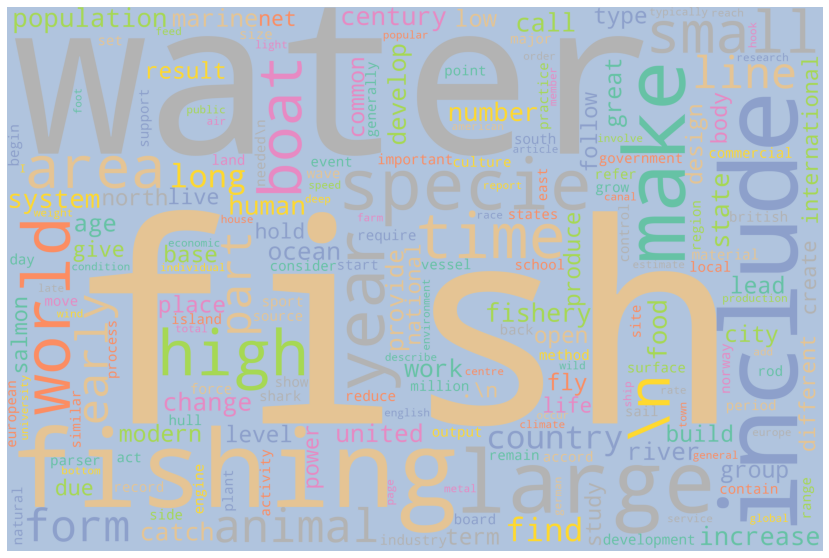

In [18]:
image = generateWordCloud(freqDict_clr)
plotWordCloud(image)

Task 6. Preprocess the raw scraped tweets with keyword ’fishing’ you’ve collected in the last assignment in the same way as you preprocess the wiki texts.

In [20]:
# Here is a function you could load the tweet text data if your saved data follows
# the format we provide the in last lab section code.

import csv

def loadTweetTextFromCSV(csvPath):
  tweetDict = {}
  with open(csvPath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      tweetDict[int(row['idx'])] = row['tweetText']
  return tweetDict

csvPathFish = "/content/drive/My Drive/CS505/tweetsFishing.csv"
rawTweetDictFish = loadTweetTextFromCSV(csvPathFish)

processedTweetData = preprocess(rawTweetDictFish) 

100%|██████████| 7957/7957 [1:06:36<00:00,  1.99it/s]


In [21]:
import numpy as np
np.save('/content/drive/My Drive/CS505/fishing_processedTweetData.npy', processedTweetData)

In [22]:
processedTweetData = np.load('/content/drive/My Drive/CS505/fishing_processedTweetData.npy',allow_pickle='TRUE').item()

Task 7. Compute how many **word types** in your tweets are out-of-vocabulary (out of Wiki vocabulary Dict), divided by the number of **word types** in your tweets. Show the value in percentage (%).

In [23]:
# get the vocabulary dict of tweets data
freqTweetData = computeFreq(processedTweetData)

def percentage(part, whole):
    Percentage = round(100 * float(part)/float(whole), 2)
    return str(Percentage) + "%"

def computeOOVWordTypes(tweetVocabDict, wikiVocabDict):

    # Input: a dictionary of tweet data vocabulary, a dictionary of wiki data vocabulary.
    # Output: the ratio of word types in your tweets that are out-of-vocabulary w.r.t. wiki vocabulary
    # v.s. total number of word types in your tweet data.
    tweetVocab_list = list(tweetVocabDict.keys())
    wikiVoca_list   = list(wikiVocabDict.keys())
    out_of_vocab = 0
    for key in tweetVocab_list:
        if key not in wikiVoca_list:
            out_of_vocab += 1
    
    return(percentage(out_of_vocab, len(tweetVocab_list)))

In [24]:
computeOOVWordTypes(freqTweetData, freqDict)

'44.13%'

Task 8. Compute how many **word tokens** in your tweets are out of vocabulary, divided by the number of **word tokens** in your tweets. (This is the OOV-rate of your tweet test set.)

In [25]:
def computeOOVWordTokens(tweetVocabDict, wikiVocabDict):

    # Input: a dictionary of tweet data vocabulary, a dictionary of wiki data vocabulary. (E.g. computed from task 3)
    # Output: the ratio of word tokens in your tweets that are out-of-vocabulary w.r.t. wiki vocabulary
    # v.s. total number of word tokens in your tweet data.

    tweetVocab_list = list(tweetVocabDict.keys())
    wikiVoca_list   = list(wikiVocabDict.keys())
    out_of_token = 0
    for key in tweetVocab_list:
        if key not in wikiVoca_list:
            out_of_token = out_of_token + tweetVocabDict[key]
    sum_token = 0
    for key in tweetVocab_list:
        sum_token = sum_token + tweetVocabDict[key]
    
    return(percentage(out_of_token, sum_token))

In [26]:
computeOOVWordTokens(freqTweetData, freqDict)

'8.32%'

Task 9. Get the first 9,000 sentences from the processed Wikipedia data from task 2, train a trigram Add-one-smoothing language model based
on these 9,000 sentences (which you should have done so in the last assignment). 

(You could consider using the language model from NLTK.)


In [ ]:
!pip install nltk

In [28]:
import nltk
from nltk import word_tokenize
from nltk.lm import MLE
from nltk.lm.preprocessing import pad_both_ends, padded_everygram_pipeline
from nltk.util import bigrams, trigrams

def trainLanguageModel(processedWikiData, n):
    train_data, padded_sents = padded_everygram_pipeline(n, processedWikiData)
    model = MLE(n)
    model.fit(train_data, padded_sents)
    print(model.vocab)
    return model

In [29]:
pageDict_sents = []
for key in list(wikiDict.keys()):
    for sent in wikiDict[key]:
        pageDict_sents.append(sent)
train_sents = pageDict_sents[:9000]
test_sents = pageDict_sents[9000:11000]

In [31]:
model = trainLanguageModel(train_sents, 3)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 18684 items>


Task 10. Report the average perplexity of this Wikipedia-trained language model on your processed Twitter test sentences (i.e. the 20% split) related to "fishing". Compare this perplexity to the one you obtained in task 4 of the last assignment, specifically, the trigram LM trained on tweets. 

In [34]:
def computePerplexity(model,testData):
    test = list(trigrams(pad_both_ends(testData, n=3)))
    perplexity = model.perplexity(test)
    return(perplexity)

def computeAvePerplexity(model, testData):
    score = []
    for sent in testData:
        score.append(computePerplexity(model, sent))
    filtered_score = []
    for i in score:
        if not ((np.isnan(i)) or (i == float('Inf')) or (i == float('-Inf'))):
            filtered_score.append(i)
    return(round(sum(filtered_score)/len(filtered_score), 2))

In [35]:
print('Mean perplexity of Wiki test data = ', computeAvePerplexity(model, test_sents))

Mean perplexity of Wiki test data =  5.11


Task 11. Scrap 100 news from both ABC news and Fox news (100 each) with the code provided in the first lab section. Preprocess the texts in the same way as task 2.

In [36]:
import requests
from bs4 import BeautifulSoup

abcNewsSitemap = getPageFromWiki("https://abcnews.go.com/xmlLatestStories")
foxNewsSitemap = getPageFromWiki("https://www.foxnews.com/sitemap.xml?type=news") 

In [ ]:
#install newspaper
!pip install newspaper3k

In [ ]:
#Try getting 100 news URLs from the sitemap. 
def getUrlList(sitemap):
    # This function should return a list of URLs of news contained in the sitemap page.
    url_list = []
    for loc in sitemap.find_all('loc'):
        url_list.append(loc.string) 

    return url_list

foxUrlList = []
abcUrlList = []

foxUrlList = getUrlList(foxNewsSitemap)[:100]  # over than 100
abcUrlList = getUrlList(abcNewsSitemap)  # only 52

# Test here if the list contains the URLs you want.
print("foxUrlList",foxUrlList)
print("abcUrlList",abcUrlList)

In [54]:
from newspaper import Article
from tqdm import tqdm

def getNewsDict(url_list):
    newsDict = {}
    for url in tqdm(url_list): 
        # set up a loop to , set a delay at each iteration
        page = getPageFromWiki(url)
        header = getHeading(page)
        content = getContent(page)
        newsDict[header] = content
        time.sleep(1) 
        # Remember to set a delay >=1 second so you won't break the server.
    return newsDict

In [55]:
abcNews = getNewsDict(abcUrlList)
foxNews = getNewsDict(foxUrlList)

100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


In [56]:
#Lastly, write them down in a .csv file for both the abc and fox news. 

import csv

driveFolderDirectory = '/content/drive/My Drive/CS505/newsContents.csv' 
pathToSave = driveFolderDirectory

with open(pathToSave, 'w', newline='') as csvfile:
  fieldnames = ['idx','newsSource','newsTitle','newsContents']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()
  for i,newsDictKey in enumerate(abcNews.keys()):
    writer.writerow({'idx': i,'newsSource':'ABCNews', 'newsTitle': newsDictKey,'newsContents': abcNews[newsDictKey]})
  for i,newsDictKey in enumerate(foxNews.keys()):
    writer.writerow({'idx': i,'newsSource':'FoxNews', 'newsTitle': newsDictKey,'newsContents': foxNews[newsDictKey]})

In [57]:
def loadNewsTexts(csvPath):
    abcNewsRawTextDict = {}
    foxNewsRawTextDict = {}
    with open(csvPath, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in reader:
        if (row['newsSource'] == "ABCNews"):
          abcNewsRawTextDict[row['newsTitle']] = row['newsContents']
        else:
          foxNewsRawTextDict[row['newsTitle']] = row['newsContents']

    return abcNewsRawTextDict,foxNewsRawTextDict

In [62]:
abcNewsRawTextDict,foxNewsRawTextDict = loadNewsTexts('/content/drive/My Drive/CS505/newsContents.csv')

In [63]:
abcNewsDict = preprocess(abcNewsRawTextDict)
foxNewsDict = preprocess(foxNewsRawTextDict)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Task 12. Construct a histogram of word count from both sources. The X-axis should be unique words in decending order of word count and the Y-axis should be the counts for each word.

(Please remember to preprocess the text data first.)

In [84]:
sorted_abcNewsFreq = dict(sorted(computeFreq(abcNewsDict).items(), key=operator.itemgetter(1),reverse=True))
sorted_foxNewsFreq = dict(sorted(computeFreq(foxNewsDict).items(), key=operator.itemgetter(1),reverse=True))

# anti join stopping words
abcNewsFreq_clr_keys = []
for word in list(sorted_abcNewsFreq.keys()):
    if not word in stopwords.words():
      abcNewsFreq_clr_keys.append(word)

foxNewsFreq_clr_keys = []
for word in list(sorted_foxNewsFreq.keys()):
    if not word in stopwords.words():
      foxNewsFreq_clr_keys.append(word)

In [85]:
# anti join non english words
abcNewsFreq_en_keys = []
for word in abcNewsFreq_clr_keys:
    if word.isalpha():
        abcNewsFreq_en_keys.append(word)

foxNewsFreq_en_keys = []
for word in foxNewsFreq_clr_keys:
    if word.isalpha():
        foxNewsFreq_en_keys.append(word) 

In [93]:
sorted_abcNewsFreq_clr = {}
for key in abcNewsFreq_en_keys:
    sorted_abcNewsFreq_clr[key] = sorted_abcNewsFreq[key]

sorted_foxNewsFreq_clr = {}
for key in foxNewsFreq_en_keys:
    sorted_foxNewsFreq_clr[key] = sorted_foxNewsFreq[key]

In [88]:
import matplotlib.pyplot as plt

def plotHistogram(wordType,wordType_counts, title = None):
    fig = plt.figure()
    plt.bar(wordType, wordType_counts, width=0.5, color='purple')
    plt.xlabel('word type') 
    plt.ylabel('counts') 
    plt.title(title)
    plt.xticks(rotation=90)
    plt.close()
    return(fig)

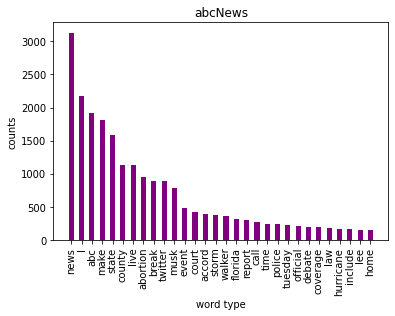

In [96]:
plotHistogram(list(sorted_abcNewsFreq_clr.keys())[:30], list(sorted_abcNewsFreq.values())[:30], "abcNews")

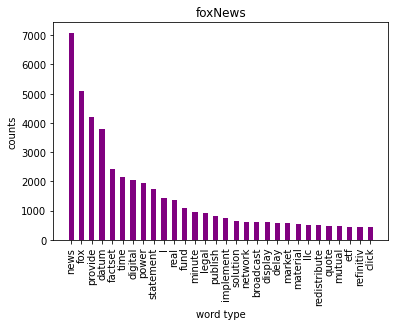

In [97]:
plotHistogram(list(sorted_foxNewsFreq_clr.keys())[:30], list(sorted_foxNewsFreq.values())[:30], "foxNews")

Task 13. Construct the word clouds from the two texts. Include the word clouds and comment your interesting insights after that.

13.1 abc News wordcloud

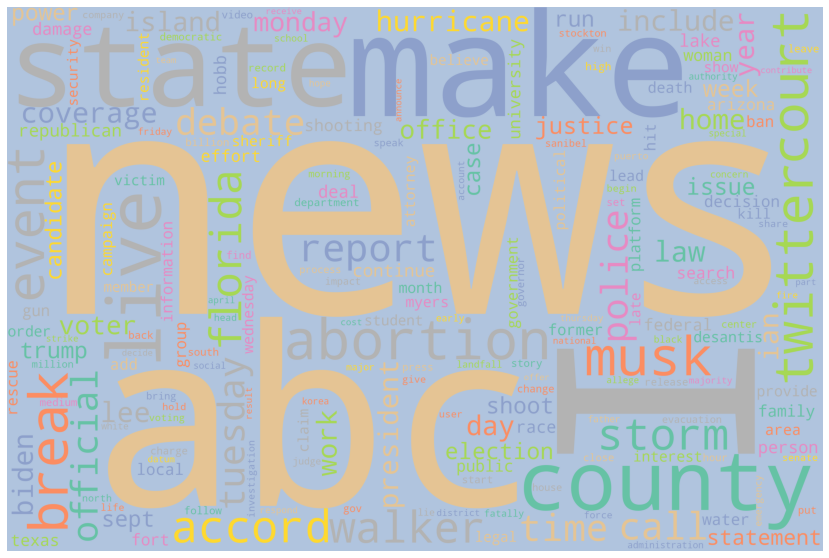

In [98]:
image_abc = generateWordCloud(sorted_abcNewsFreq_clr)
plotWordCloud(image_abc)

13.2 Fox News wordcloud

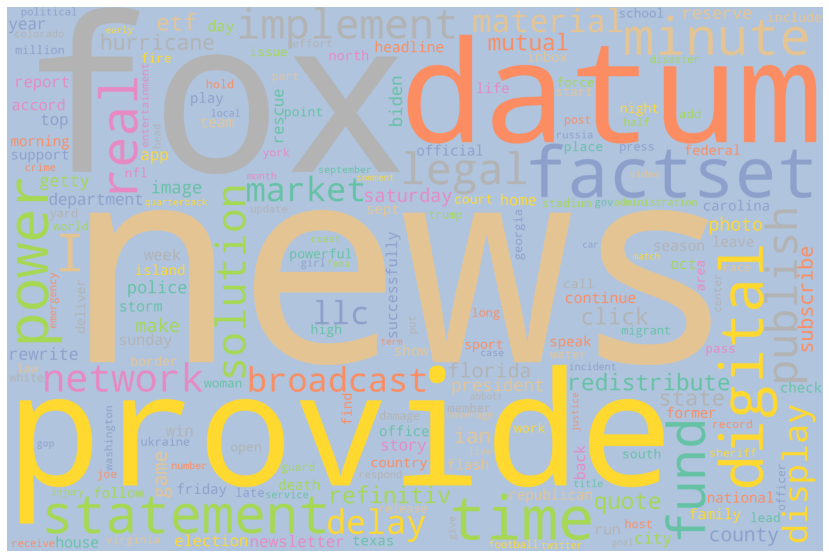

In [99]:
image_fox = generateWordCloud(sorted_foxNewsFreq_clr)
plotWordCloud(image_fox)